<a href="https://colab.research.google.com/github/Pataweepr/applyML_vistec_2019/blob/master/hw2_homeDotTech_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from sklearn.cluster import KMeans

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mode
from sklearn import preprocessing

คุณควร run code ตัวของ example เพื่อทราบถึง file id เพราะว่า file id ของแต่ละคนนั้นไม่เหมือนกันน่ะครับ  [example pyDrive](https://colab.research.google.com/drive/1pIl9zCObPc_8BLivb7FRsjYBhKGWK9eL)


###FILE_ID!!!

<pre>   
title: userLog_201801_201802_for_participants.csv, id: 19sNUEOYeqU33EWBMRKq65YydpgLQoppZ
title: project_main.csv, id: 1iRz0edC_tjIk0Ge33fKLZYN1ciXxup-0
title: project_facility.csv, id: 13jUinwDsk9sYvoMOBaTMfTM11912CvdO
</pre>


เนื่องจากข้อมูลใน file เป็น รูปแบบการแยกข้อมูล ใน column แยกด้วย ';' แต่ว่ามันยากที่จัดการ เลยเขียน function เพื่ออ่าน file ดังนี้

In [0]:
def readDataFromDrive_HDT_single_col(file_id):
  # file_id is str
    data_downloaded = drive.CreateFile({'id': file_id })
    data_downloaded.GetContentFile('readCsvFile.csv')
    raw_data = pd.read_csv('readCsvFile.csv',delimiter= ';')
    return raw_data;

file ที่เราจะเลือกใช้

* userLog
* project_main
* project_facility


userLog  มันการเป็นเก็บ log ของ user ทั้งหมดที่เข้ามาในระบบ ว่า user เข้าผ่านอุปกรณื อะไรบ้างแล้วเข้าไปดูโปรเจคไหน

project_main เป็นการบอกรายละเอียดแต่ละ project ว่ามีข้อมูลอะไรบ้าง เกี่ยวกับตำแหน่ง หรือ ตัวของ ราคา

project_facility บอก facility ของแต่ละโปรคเจคว่าเป็นอย่างไร





# TODO#1: เปลี่ยนข้อมูลเป็นตัวเลข

ข้อมูบบที่เราจะพิจารณาต่อไปนี้เป็นข้อมูล

In [4]:
print('project_main')
project_main = readDataFromDrive_HDT_single_col('1iRz0edC_tjIk0Ge33fKLZYN1ciXxup-0')  
project_main = project_main.loc[project_main['province_id'] == 10]
print(project_main.shape)
project_main = project_main.drop(columns=['project_land_size_ngan', 'project_land_size_wa'])
project_main.loc[project_main["project_status"] == "A", "project_status"] = 1
project_main.loc[project_main["project_status"] == "U", "project_status"] = 0
project_main = project_main.convert_objects(convert_numeric=True)
project_main.head()

project_main
(1775, 18)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


,project_id,developer_id,brand_id,project_name_th,project_name_en,district_id,province_id,lat,lon,project_land_size_rai,total_unit,percent_car_parking,starting_price,highest_price,project_status,created_at
0,44,140786,0.0,พาร์ควิลล์ 3,Parkville 3,1046.0,10,13.891719,100.722099,54,NaN,NaN,3500000.0,3862000.0,1.0,2011-01-14T18:40:12.117+0700
1,24,1032,0.0,สัมมากร นิมิตใหม่,Sammakorn Nimitmai,1046.0,10,13.876590,100.731927,154,NaN,NaN,4590000.0,NaN,0.0,2011-02-24T21:43:59.297+0700
7,208,13323,NaN,ลิฟวิ่งนารา รามคำแหง-สุวรรณภูมิ,LIVING NARA RAMKHAMHAENG-SUVARNABHUMI,1011.0,10,13.769810,100.722040,44,201.0,NaN,3500000.0,7600000.0,0.0,2010-07-02T07:00:00.000+0700
8,228,6772,0.0,เค.ซี.รามอินทรา 5 (พระยาสุเรนทร์),K.C. RAMINTRA 5,1046.0,10,13.862623,100.695135,34,NaN,NaN,1810000.0,NaN,0.0,2010-12-16T18:51:42.173+0700
11,982,12136,979.0,อนาวิลล์ สุวรรณภูมิ,Anaville Suvarnabhumi,1011.0,10,13.763348,100.803434,131,NaN,NaN,4300000.0,NaN,1.0,2011-01-17T22:55:47.317+0700


# TODO#2: แก้ไขข้อมูล data frame ของ projet_main ให้ไม่มี NAN

In [0]:

project_main = project_main.dropna(subset=['lat'])

project_main["starting_price"] = project_main["starting_price"].fillna(project_main["starting_price"].mode().iloc[0])


## TODO#3: load ข้อมูล facility
ลอง print ข้อมูลดูเราจะเห็นว่าข้อมูล และอธิบายว่าเหมาะสมกับการใช้หรือไม่


In [6]:
# project_facility  
project_facility = readDataFromDrive_HDT_single_col('13jUinwDsk9sYvoMOBaTMfTM11912CvdO')
project_facility.head()

,project_id,facility_id
0,4,1
1,4,3
2,4,4
3,4,5
4,45,2



## TODO#4: แปลงข้อมูล fac ให้เหมาะแก้การใช้งาน 
เนื่องจากข้อมูลไม่ได้เป็นรูปแบบของตารางที่ใช้ได้ง่าย [pd.crosstab](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.crosstab.html) เพราะ เราต้องการตารางที่บอกถึง facility ว่ามีหรือไม่ในทุกแบบของ facility

In [7]:
project_facility_table = pd.crosstab(project_facility['project_id'], project_facility['facility_id'], rownames=['project_id'], colnames=['facility_id'])
print(project_facility_table.index)
project_facility_table.head()

Int64Index([   4,   24,   29,   41,   44,   45,   73,   95,  115,  133,
            ...
            9522, 9524, 9525, 9526, 9527, 9531, 9532, 9534, 9536, 9541],
           dtype='int64', name='project_id', length=5039)


facility_id,1,2,3,4,5,6
project_id,,,,,,
4,1,0,1,1,1,0
24,0,0,1,1,0,1
29,0,0,0,0,1,0
41,1,1,0,1,0,1
44,1,0,1,0,0,0


## TODO#5: กำจัดข้อมูลที่ใช้ไม่ได้ ออกไป เลือกใช้แต่ข้อมูลที่ครบ

เราจำเป็นต้องแยกข้อมูลให้เหลือ project ที่มีข้อมูลครบ เท่านั้น  เราสามารถใช้ [pandas.DataFrame.isin](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html) เพื่อช่วยในการหา วา่มีข้อมูลร่วมกันได้ในการแยกข้แมูลออกมา

In [8]:
project_facility_table = project_facility_table.loc[project_facility_table.index.isin(project_main['project_id'])]
project_main = project_main.loc[project_main['project_id'].isin(project_facility_table.index.astype(int))]
project_main = project_main.sort_values('project_id')
print(project_facility_table.shape)
print(project_main.shape)
project_facility_table.head()

(1697, 6)
(1697, 16)


facility_id,1,2,3,4,5,6
project_id,,,,,,
24,0,0,1,1,0,1
44,1,0,1,0,0,0
45,0,1,1,1,1,0
95,1,0,0,0,0,0
133,1,0,1,0,1,0


In [9]:
project_main.head()

,project_id,developer_id,brand_id,project_name_th,project_name_en,district_id,province_id,lat,lon,project_land_size_rai,total_unit,percent_car_parking,starting_price,highest_price,project_status,created_at
1,24,1032,0.0,สัมมากร นิมิตใหม่,Sammakorn Nimitmai,1046.0,10,13.876590,100.731927,154,NaN,NaN,4590000.0,NaN,0.0,2011-02-24T21:43:59.297+0700
0,44,140786,0.0,พาร์ควิลล์ 3,Parkville 3,1046.0,10,13.891719,100.722099,54,NaN,NaN,3500000.0,3862000.0,1.0,2011-01-14T18:40:12.117+0700
164,45,2840,0.0,พาร์คเวย์ ชาเล่ต์,parkway chalet,1010.0,10,13.803465,100.727406,87,NaN,NaN,5500000.0,NaN,0.0,2011-03-28T23:27:08.833+0700
172,95,2730,NaN,อารีน่า พาร์ค ชวนชื่น ซิตี้,NaN,1005.0,10,13.859276,100.665287,79,NaN,NaN,2000000.0,5000000.0,0.0,2007-04-18T23:02:22.000+0700
185,133,6772,538.0,เค.ซี.เลควิว,K.C. LAKEVIEW,1044.0,10,13.759440,100.679230,60,NaN,NaN,11000000.0,NaN,1.0,2011-01-14T18:42:51.630+0700


## TODO#6: ลองดูข้อมูล จาก user log 



ลอง check ข้อมูลของ log data 

In [10]:
# care values province_id
# we use only bangkok  province_id = 10 
### load data ###############################################################################
print('userLog')
userLog = readDataFromDrive_HDT_single_col('19sNUEOYeqU33EWBMRKq65YydpgLQoppZ') 
userLog.head()


userLog


,userCode,project_id,requestedDevice,userAgent,pageReferrer,year,month,day,hour
0,7717bdc2-ea3e-e8ad-5d6b-178bd71c38b2,7956,Mobile,Android,HomeWebsite,2018,1,1,0
1,7717bdc2-ea3e-e8ad-5d6b-178bd71c38b2,7956,Mobile,Android,HomeWebsite,2018,1,1,0
2,cb5b4b68-cc01-6db6-f54b-4a0f881301c5,5067,Mobile,iPhone,HomeWebsite,2018,1,1,0
3,5f74cef2-0d1e-b619-3564-0955a14e0985,6654,Mobile,iPhone,Google,2018,1,1,0
4,dba8f279-844e-eef6-73ac-22bd7d1353cc,6474,Mobile,iPad,Google,2018,1,1,0


In [11]:
print(userLog.shape)


(1234579, 9)


In [12]:
print(userLog.loc[userLog['project_id'].isin(project_facility_table.index.astype(int))].shape)
userLog = userLog.loc[userLog['project_id'].isin(project_facility_table.index.astype(int))]

(405448, 9)


## TODO#7: ข้อมูล histrogram ของตัว user และ project ที่ user ดู

จง check ดูความบ่อยของการใช้ user และ plot histogram ออกมา

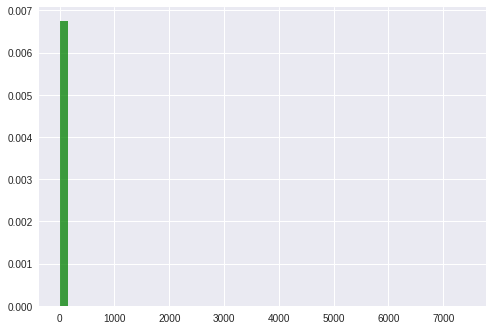

In [13]:
userLog_freq_user = userLog['userCode'].value_counts()
userLog_freq_user_np  = np.array(userLog_freq_user.values)

n, bins, patches = plt.hist(userLog_freq_user_np, 50, density=True, facecolor='g', alpha=0.75)
plt.show()

จงแสดง histogram ของความถี่ของ user และ ใช้ pd.head() เพื่อดูค่าช่วงต้นๆ ของ histogram

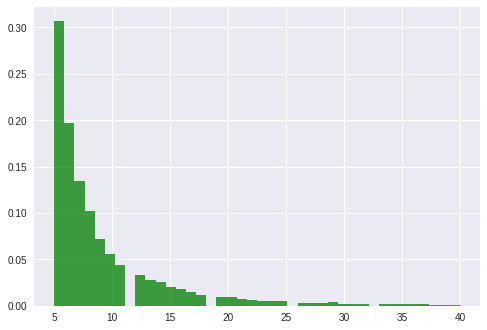

In [14]:
userLog_freq_user = userLog_freq_user.loc[userLog_freq_user <= 3000]

normal_user = userLog_freq_user.loc[userLog_freq_user >= 5]
normal_user = normal_user.loc[normal_user <= 40]
normal_user_np = np.array(normal_user.values)

n, bins, patches = plt.hist(normal_user_np, 40, density=True, facecolor='g', alpha=0.75)
plt.show()

In [15]:
userLog = userLog.loc[userLog['userCode'].isin(normal_user.index)]
userLog = userLog.loc[userLog['project_id'].isin(project_main['project_id'])] 

print(userLog.shape)

project_main = project_main.loc[project_main['project_id'].isin(userLog['project_id'])]
project_facility_table = project_facility_table.loc[project_facility_table.index.isin(userLog['project_id'])]

print(project_main.shape)
print(project_facility_table.shape)

(137784, 9)
(1530, 16)
(1530, 6)


# K-mean



การ ที่เราทำ k-mean นั้น จะขึ้นกับระยะห่างที่เราตั้งขึ้นมา ดังนั้น feature ที่มาค่า conv ที่สูงนั้นจะส่งผลต่อการคำนวนมากเพราะ ค่าของ feature มากกว่า feature อื่นๆมากเกินไป ดังนั้น ก่อนที่เราจะ ใช้ k mean เราจพเป็นต้อง normalize  feature ของเราทั้งหมดก่อน

ทดลองทำ k-mean โดยใช้ข้อมูล ของ ทำแหน่งที่ตั้ง ราคา และ facility ต่างเป็น feature

In [0]:
def normalize(x):
    min_max_scaler = preprocessing.MinMaxScaler()
    x_nor = min_max_scaler.fit_transform(x)
    return x_nor;

#split train val test

In [0]:
project_main_np_data  = np.hstack((np.array(project_main[["lat","lon","starting_price"]].values) , np.array(project_facility_table.values)))

index_data = np.arange(project_main_np_data_nor.shape[0])
np.random.shuffle(index_data)

'''
we use train:val:test = 80:10:10
'''
index_data_train = index_data[:int(project_main_np_data_nor.shape[0]*0.8)]
index_data_val = index_data[int(project_main_np_data_nor.shape[0]*0.8):int(project_main_np_data_nor.shape[0]*0.9)]
index_data_test = index_data[int(project_main_np_data_nor.shape[0]*0.9):]

project_main_np_train = project_main_np_data[index_data_train,:]
project_main_np_val = project_main_np_data[index_data_val,:]
project_main_np_test = project_main_np_data[index_data_test,:]

## แผนที่ กทม.

![Bangkok](https://www.img.in.th/images/02f4f215d503eca7777857e07f6a2b54.md.png)


[link text](https://www.img.in.th/image/DYfJKa)

แสดงผลลัพธ์การ รัน k mean ออกมา

> Indented block



[K-means example](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html)

[function in Kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

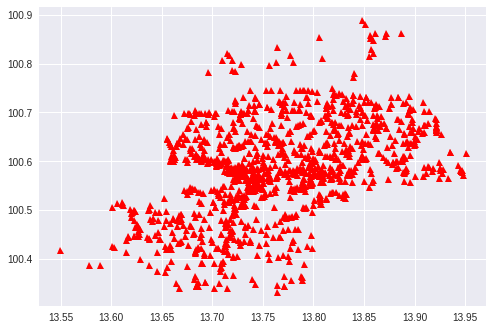

================================ k =  2 ============================================
==================================  training set ==========================================


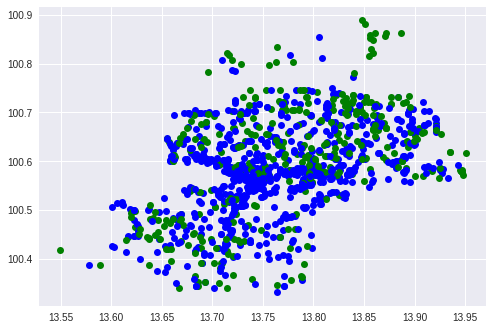

==================================  validation set ==========================================


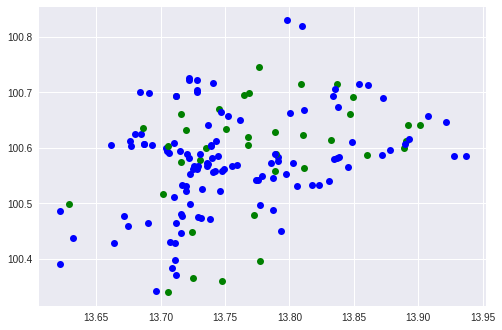

==================================== end ========================================
================================ k =  3 ============================================
==================================  training set ==========================================


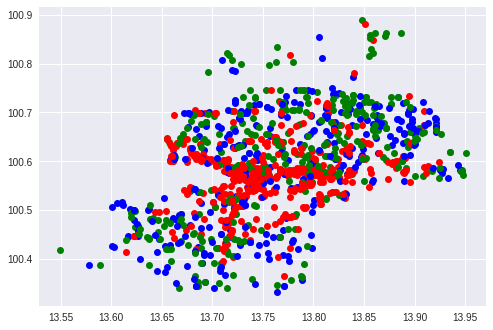

==================================  validation set ==========================================


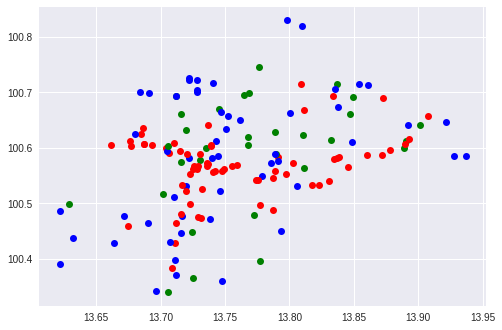

==================================== end ========================================
================================ k =  4 ============================================
==================================  training set ==========================================


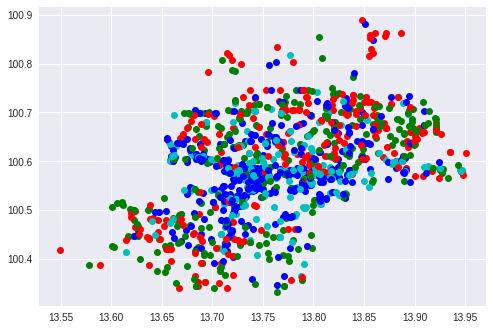

==================================  validation set ==========================================


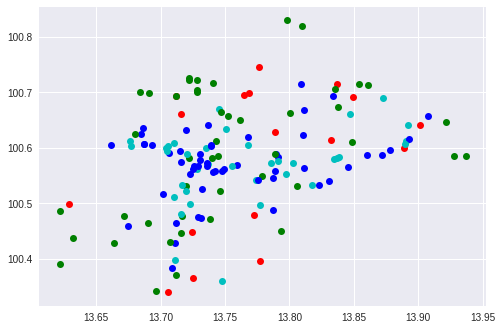

==================================== end ========================================
================================ k =  5 ============================================
==================================  training set ==========================================


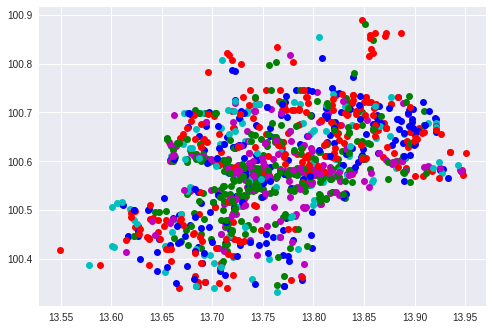

==================================  validation set ==========================================


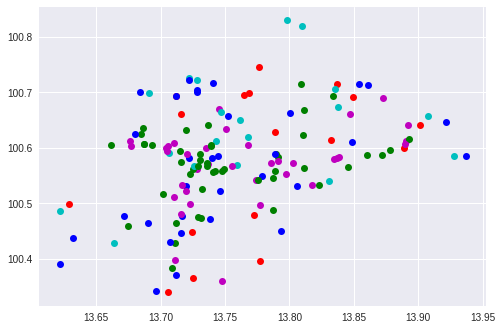

==================================== end ========================================
================================ k =  6 ============================================
==================================  training set ==========================================


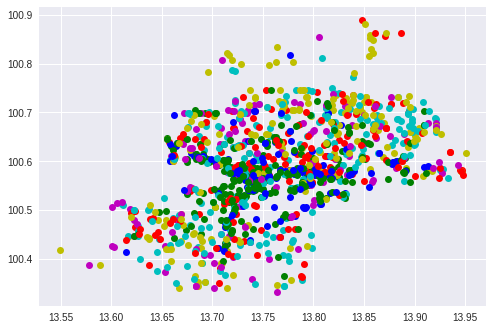

==================================  validation set ==========================================


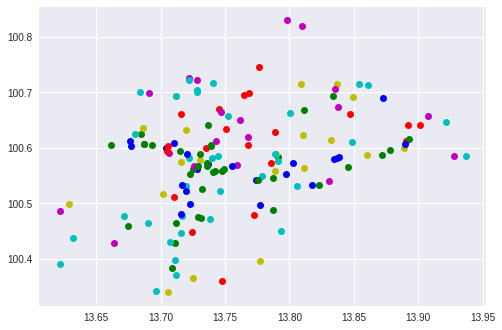

==================================== end ========================================
================================ k =  7 ============================================
==================================  training set ==========================================


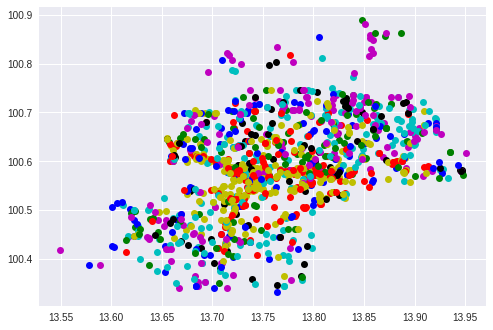

==================================  validation set ==========================================


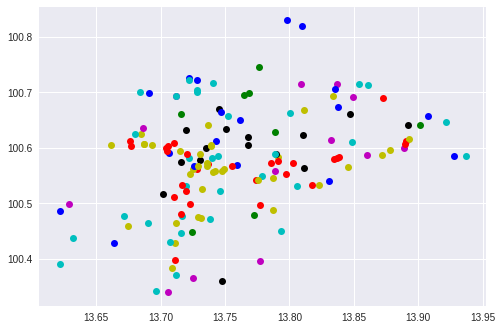

==================================== end ========================================
================================ k =  8 ============================================
==================================  training set ==========================================


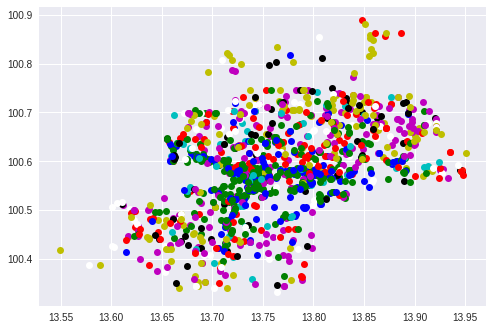

==================================  validation set ==========================================


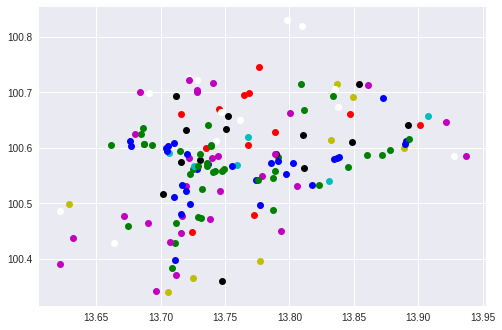

==================================== end ========================================


In [19]:
project_main_np_data_nor  = normalize(project_main_np_data)
project_main_np_nor_train = project_main_np_data_nor[index_data_train,:]
project_main_np_nor_val = project_main_np_data_nor[index_data_val,:]
project_main_np_nor_test = project_main_np_data_nor[index_data_test,:]

plt.plot(project_main_np_train[:,0], project_main_np_train[:,1], 'r^')
plt.show()
##

kmean_result =  KMeans(n_clusters=8).fit(project_main_np_nor_train)
# print(kmean_result.labels_)
### k-mean 
colors = ['bo', 'go', 'ro', 'co', 'mo', 'yo', 'ko', 'wo']
for k in np.arange(2,len(colors) + 1):
    print('============================================================================')
    kmean_result =  KMeans(n_clusters = k).fit(project_main_np_nor_train)
    print('================================ k = ', k ,'============================================')
    print('==================================  training set ==========================================')
    for i in np.arange(project_main_np_train.shape[0]):
        plt.plot(project_main_np_train[i,0], project_main_np_train[i,1], colors[kmean_result.labels_[i]])
    plt.show()
    print('==================================  validation set ==========================================')
    y_pred = kmean_result.predict(project_main_np_nor_val)
    for i in np.arange(project_main_np_val.shape[0]):
        plt.plot(project_main_np_val[i,0], project_main_np_val[i,1], colors[y_pred[i]])
    plt.show()
    print('==================================== end ========================================')
##


## สำหรับการ visualization ด้วย T-sne

In [21]:
'''

def plot_with_labels(low_dim_embs, labels, filename="tsne_plot.png"):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    fp = mpl.font_manager.FontProperties(family='TH KoHo',size=17)
    plt.figure(figsize=(15, 15))  # in inches
    plt.axis('off')
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontproperties=fp)


    plt.show()
    plt.savefig(filename)
    

from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500)
plot_only = 500 #only top 500 words
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

'''

"\nfrom sklearn.manifold import TSNE\ntsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500)\nplot_only = 500 #only top 500 words\nlow_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])\nlabels = [reverse_dictionary[i] for i in range(plot_only)]\nplot_with_labels(low_dim_embs, labels)\n\n"

## run test set by using best ' k '   

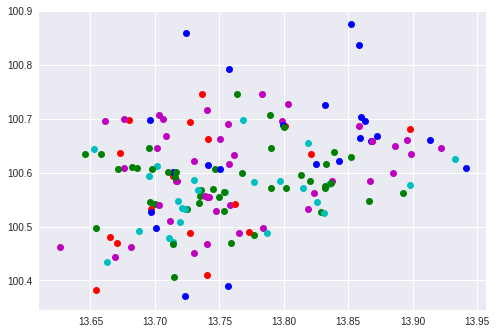

In [22]:
best_k = 5

kmean_result =  KMeans(n_clusters = best_k).fit(project_main_np_nor_train)
y_pred = kmean_result.predict(project_main_np_nor_test)

for i in np.arange(project_main_np_nor_test.shape[0]):
    plt.plot(project_main_np_test[i,0], project_main_np_test[i,1], colors[y_pred[i]])
plt.show()


แสดงความคิดเห็นกับข้อมูลที่ visual ออกมา


## นับการเข้าชม (เข้ากี่ครั้ง) เป็น feature ในการหาค่า k-mean

================================ k =  2 ============================================
==================================  training set ==========================================


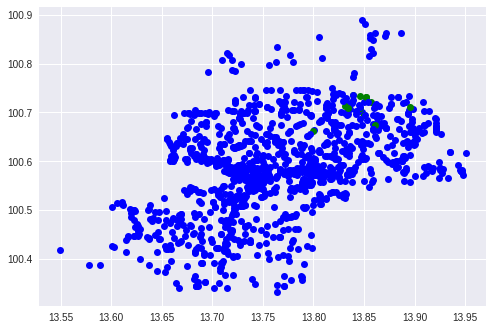

==================================  validation set ==========================================


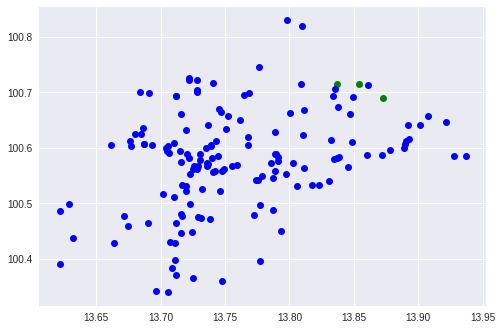

==================================== end ========================================
================================ k =  3 ============================================
==================================  training set ==========================================


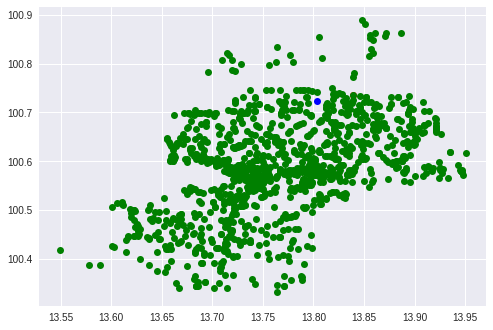

==================================  validation set ==========================================


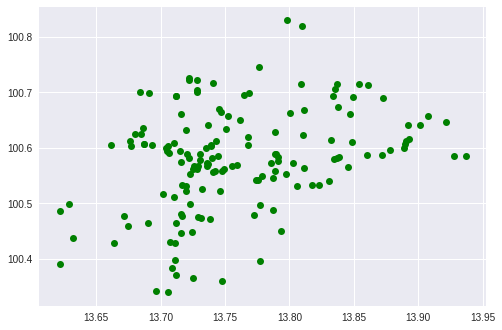

==================================== end ========================================
================================ k =  4 ============================================
==================================  training set ==========================================


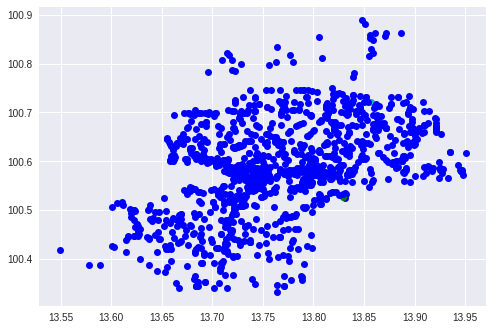

==================================  validation set ==========================================


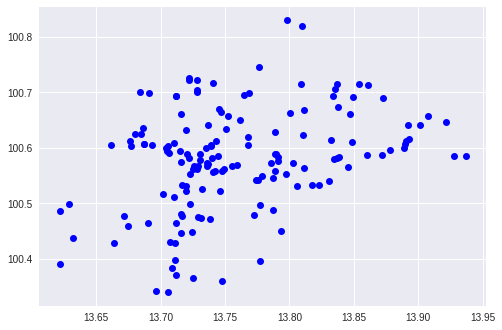

==================================== end ========================================
================================ k =  5 ============================================
==================================  training set ==========================================


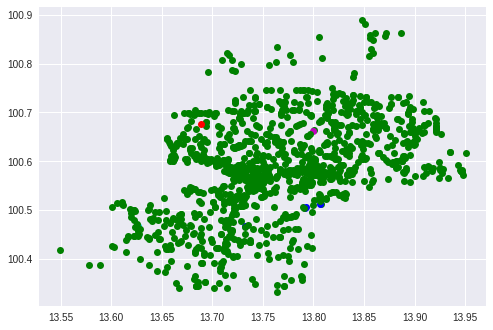

==================================  validation set ==========================================


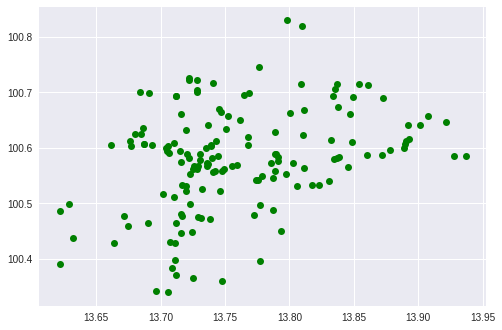

==================================== end ========================================
================================ k =  6 ============================================
==================================  training set ==========================================


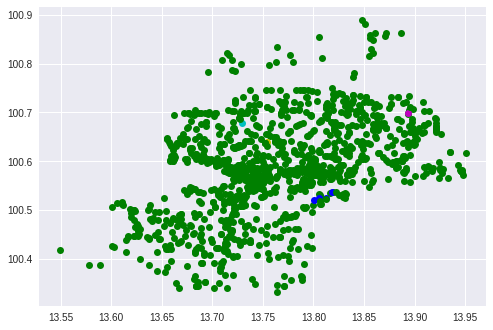

==================================  validation set ==========================================


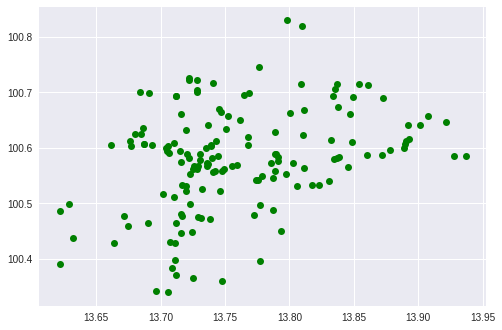

==================================== end ========================================
================================ k =  7 ============================================
==================================  training set ==========================================


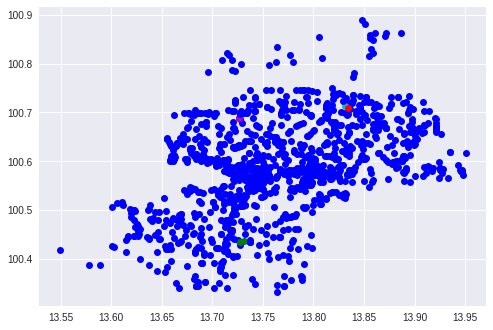

==================================  validation set ==========================================


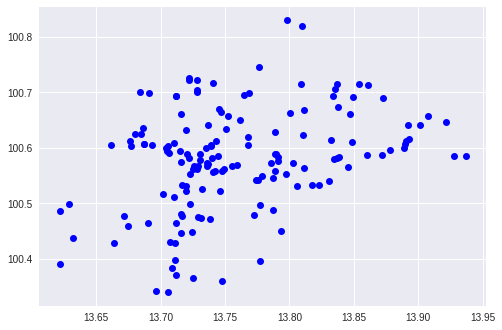

==================================== end ========================================
================================ k =  8 ============================================
==================================  training set ==========================================


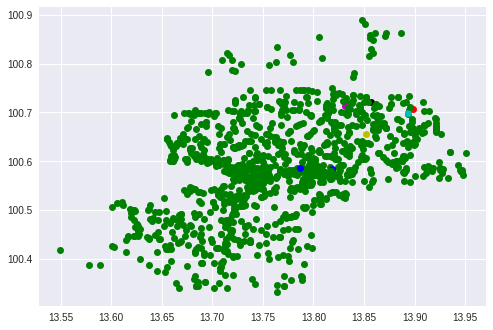

==================================  validation set ==========================================


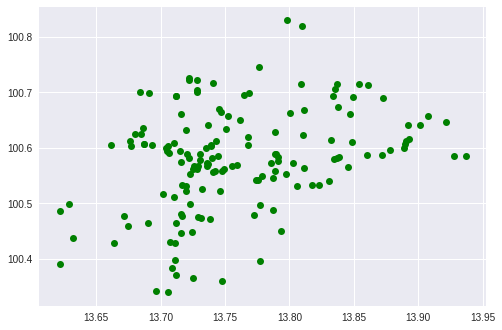

==================================== end ========================================


In [24]:
'''
index_data_train = index_data[:int(project_main_np_data_nor.shape[0]*0.8)]
index_data_val = index_data[int(project_main_np_data_nor.shape[0]*0.8):int(project_main_np_data_nor.shape[0]*0.9)]
index_data_test = index_data[int(project_main_np_data_nor.shape[0]*0.9):]
'''

freq_user_seen_proj = pd.crosstab(userLog['project_id'], userLog['userCode'], rownames=['project_id'], colnames=['userCode'])
freq_user_seen_proj_np = np.array(freq_user_seen_proj.values)
freq_user_seen_proj_np = normalize(freq_user_seen_proj_np)

freq_user_seen_proj_np_train = freq_user_seen_proj_np[index_data_train,:]
freq_user_seen_proj_np_val = freq_user_seen_proj_np[index_data_val,:]
freq_user_seen_proj_np_test = freq_user_seen_proj_np[index_data_test,:]


for k in np.arange(2,len(colors) + 1):
    print('============================================================================')
    kmean_result =  KMeans(n_clusters = k).fit(freq_user_seen_proj_np_train)
    print('================================ k = ', k ,'============================================')
    print('==================================  training set ==========================================')
    for i in np.arange(project_main_np_train.shape[0]):
        plt.plot(project_main_np_train[i,0], project_main_np_train[i,1], colors[kmean_result.labels_[i]])
    plt.show()
    print('==================================  validation set ==========================================')
    y_pred = kmean_result.predict(freq_user_seen_proj_np_val)
    for i in np.arange(project_main_np_val.shape[0]):
        plt.plot(project_main_np_val[i,0], project_main_np_val[i,1], colors[y_pred[i]])
    plt.show()
    print('==================================== end ========================================')

## test your model

In [0]:
best_k = 5

kmean_result =  KMeans(n_clusters = best_k).fit(freq_user_seen_proj_np_train)
y_pred = kmean_result.predict(freq_user_seen_proj_np_test)

for i in np.arange(freq_user_seen_proj_np_test.shape[0]):
    plt.plot(project_main_np_test[i,0], project_main_np_test[i,1], colors[y_pred[i]])
plt.show()

## นับการเข้าชม (เข้า / ไม่เข้า) เป็น feature ในการหาค่า k-mean

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


================================ k =  2 ============================================
==================================  training set ==========================================


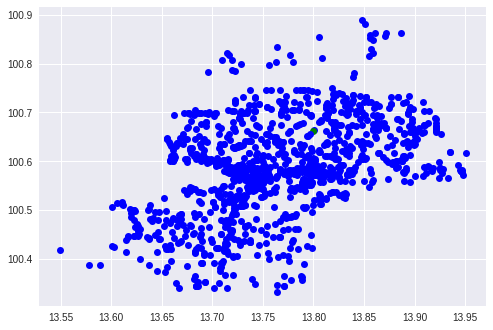

==================================  validation set ==========================================


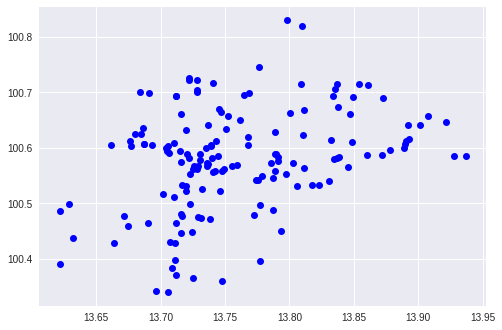

==================================== end ========================================
================================ k =  3 ============================================
==================================  training set ==========================================


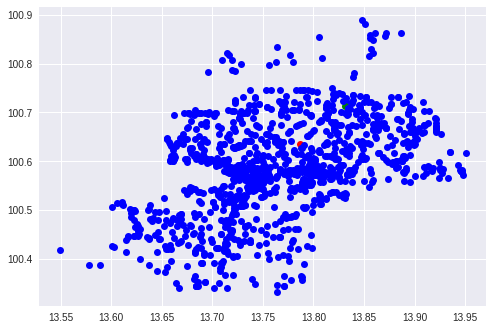

==================================  validation set ==========================================


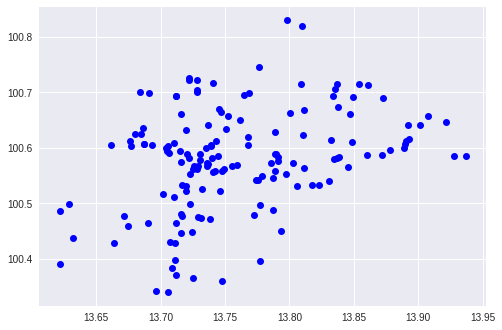

==================================== end ========================================
================================ k =  4 ============================================
==================================  training set ==========================================


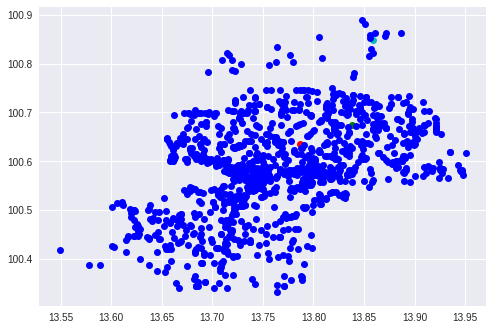

==================================  validation set ==========================================


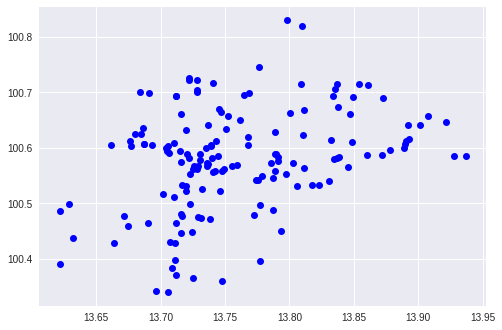

==================================== end ========================================
================================ k =  5 ============================================
==================================  training set ==========================================


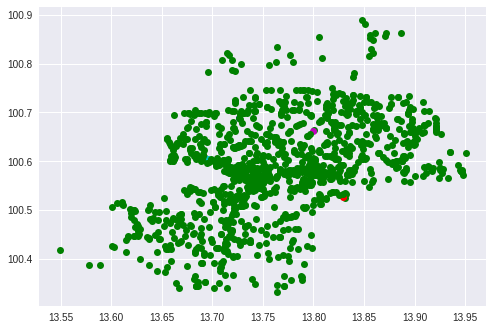

==================================  validation set ==========================================


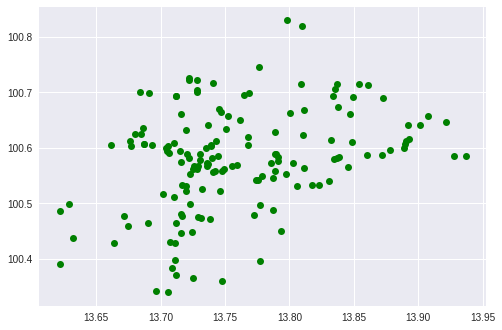

==================================== end ========================================
================================ k =  6 ============================================
==================================  training set ==========================================


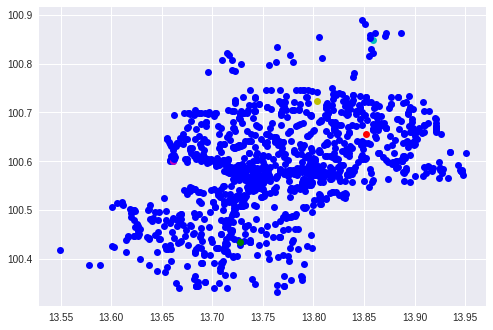

==================================  validation set ==========================================


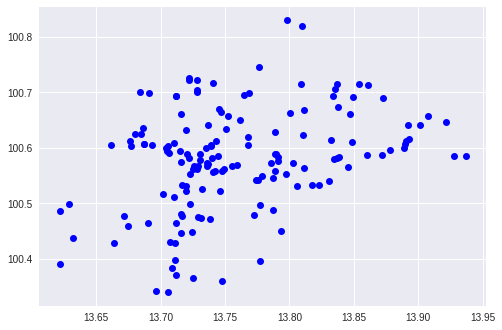

==================================== end ========================================
================================ k =  7 ============================================
==================================  training set ==========================================


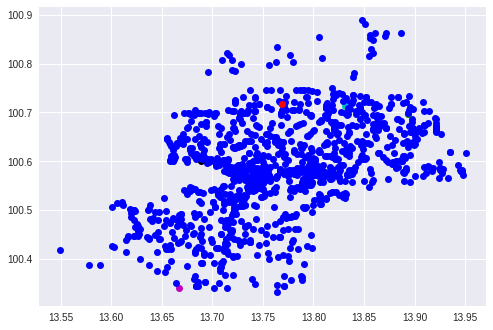

==================================  validation set ==========================================


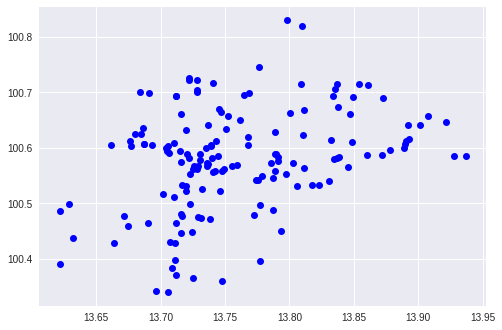

==================================== end ========================================
================================ k =  8 ============================================
==================================  training set ==========================================


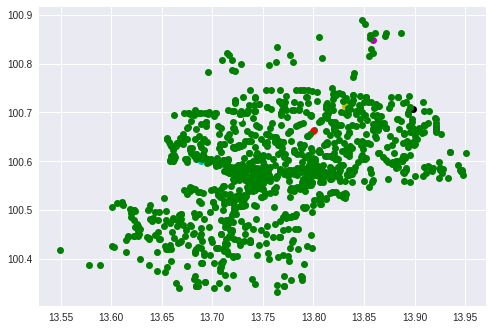

==================================  validation set ==========================================


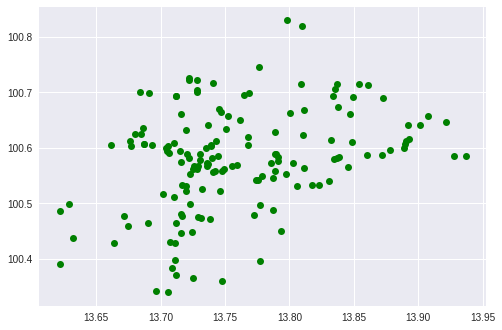

==================================== end ========================================


In [25]:
freq_user_seen_proj = pd.crosstab(userLog['project_id'], userLog['userCode'], rownames=['project_id'], colnames=['userCode'])
freq_user_seen_proj_np = np.array(freq_user_seen_proj.values)

freq_user_seen_proj_np = normalize(freq_user_seen_proj_np)

freq_user_seen_proj_np_train = freq_user_seen_proj_np[index_data_train,:]
freq_user_seen_proj_np_val = freq_user_seen_proj_np[index_data_val,:]
freq_user_seen_proj_np_test = freq_user_seen_proj_np[index_data_test,:]

freq_user_seen_proj.head()


for k in np.arange(2,len(colors) + 1):
    print('============================================================================')
    kmean_result =  KMeans(n_clusters = k).fit(freq_user_seen_proj_np_train >= 1)
    print('================================ k = ', k ,'============================================')
    print('==================================  training set ==========================================')
    for i in np.arange(project_main_np_train.shape[0]):
        plt.plot(project_main_np_train[i,0], project_main_np_train[i,1], colors[kmean_result.labels_[i]])
    plt.show()
    print('==================================  validation set ==========================================')
    y_pred = kmean_result.predict(freq_user_seen_proj_np_val >=1)
    for i in np.arange(project_main_np_val.shape[0]):
        plt.plot(project_main_np_val[i,0], project_main_np_val[i,1], colors[y_pred[i]])
    plt.show()
    print('==================================== end ========================================')

## test model 

In [0]:
best_k = 5

kmean_result =  KMeans(n_clusters = best_k).fit(freq_user_seen_proj_np_train >= 1)
y_pred = kmean_result.predict(freq_user_seen_proj_np_test >= 1)

for i in np.arange(freq_user_seen_proj_np_test.shape[0]):
    plt.plot(project_main_np_test[i,0], project_main_np_test[i,1], colors[y_pred[i]])
plt.show()

## mixed feature

================================ k =  2 ============================================
==================================  training set ==========================================


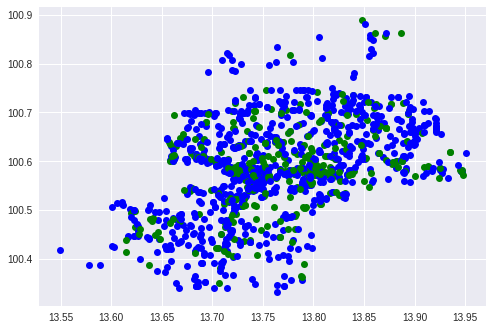

==================================  validation set ==========================================


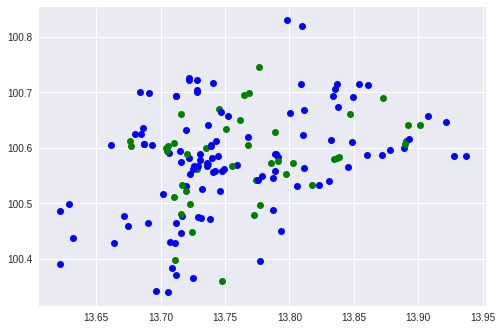

==================================== end ========================================
================================ k =  3 ============================================
==================================  training set ==========================================


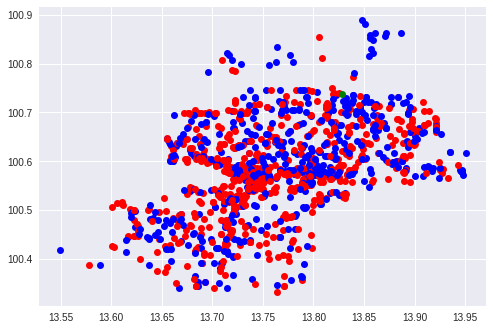

==================================  validation set ==========================================


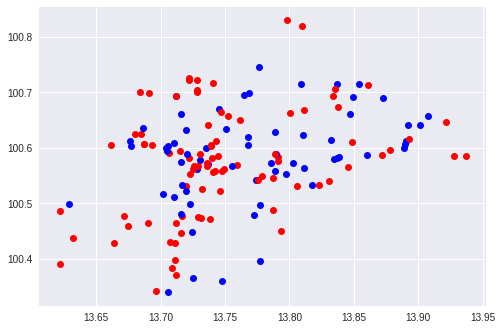

==================================== end ========================================
================================ k =  4 ============================================
==================================  training set ==========================================


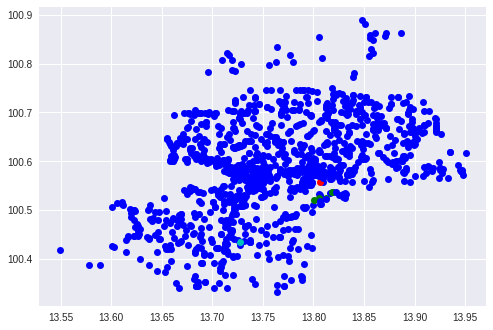

==================================  validation set ==========================================


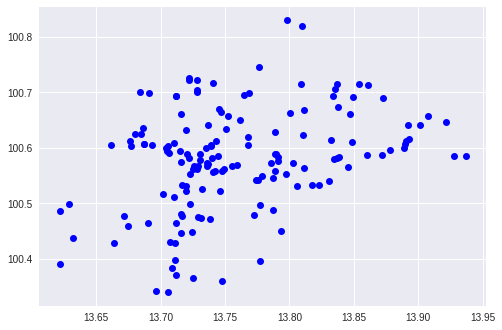

==================================== end ========================================
================================ k =  5 ============================================
==================================  training set ==========================================


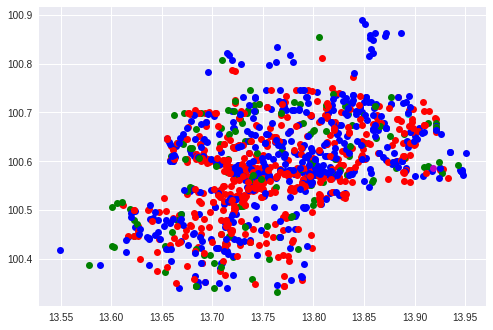

==================================  validation set ==========================================


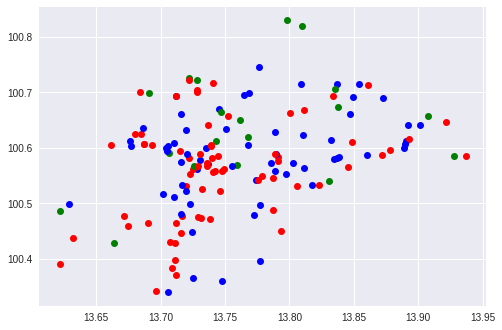

==================================== end ========================================
================================ k =  6 ============================================
==================================  training set ==========================================


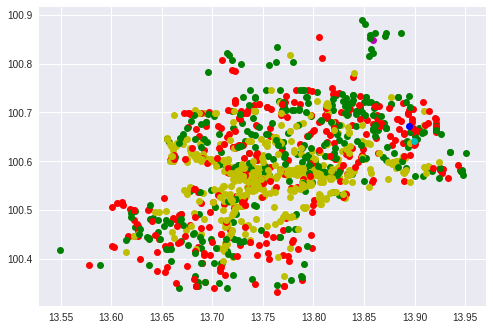

==================================  validation set ==========================================


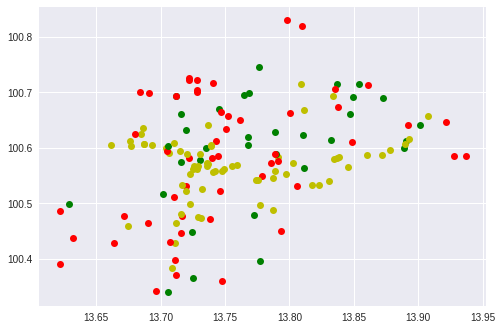

==================================== end ========================================
================================ k =  7 ============================================
==================================  training set ==========================================


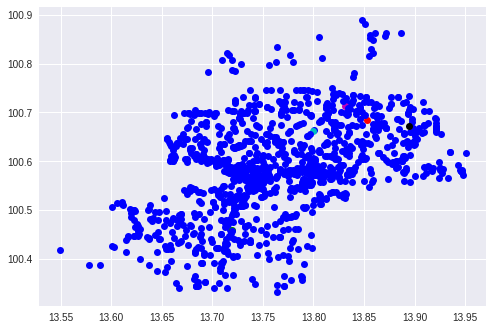

==================================  validation set ==========================================


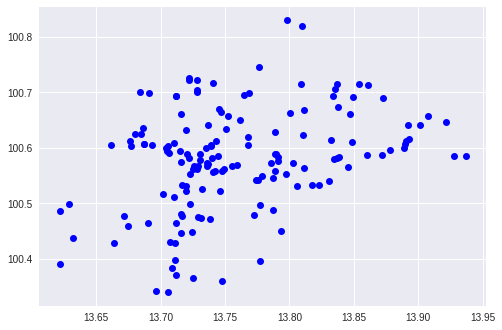

==================================== end ========================================
================================ k =  8 ============================================
==================================  training set ==========================================


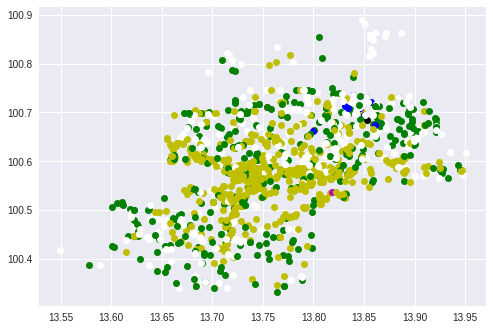

==================================  validation set ==========================================


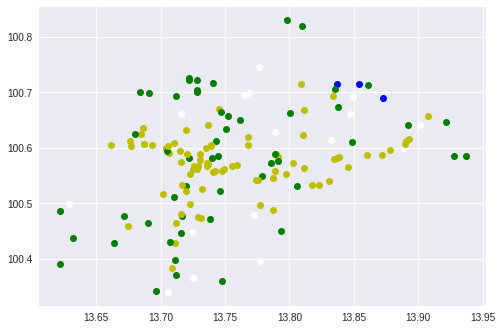

==================================== end ========================================


In [26]:
new_feature_train = np.hstack((project_main_np_nor_train  ,freq_user_seen_proj_np_train ))  
new_feature_val = np.hstack((project_main_np_nor_val  ,freq_user_seen_proj_np_val ))  
new_feature_test = np.hstack((project_main_np_nor_test  ,freq_user_seen_proj_np_test ))  


for k in np.arange(2,len(colors) + 1):
    print('============================================================================')
    kmean_result =  KMeans(n_clusters = k).fit(new_feature_train)
    print('================================ k = ', k ,'============================================')
    print('==================================  training set ==========================================')
    for i in np.arange(project_main_np_train.shape[0]):
        plt.plot(project_main_np_train[i,0], project_main_np_train[i,1], colors[kmean_result.labels_[i]])
    plt.show()
    print('==================================  validation set ==========================================')
    y_pred = kmean_result.predict(new_feature_val)
    for i in np.arange(project_main_np_val.shape[0]):
        plt.plot(project_main_np_val[i,0], project_main_np_val[i,1], colors[y_pred[i]])
    plt.show()
    print('==================================== end ========================================')

# test model

In [0]:
best_k = 5

kmean_result =  KMeans(n_clusters = best_k).fit(new_feature_train)
y_pred = kmean_result.predict(new_feature_test)

for i in np.arange(new_feature_test.shape[0]):
    plt.plot(project_main_np_test[i,0], project_main_np_test[i,1], colors[y_pred[i]])
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(15201, 1530)
